## Support Vector Regression

### Set-up

In [83]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
#import philadelphia data
philly_df = pd.read_csv('Resources/Final Compiled Data/merged_philadelphia_acs_commerce_crime_sales.csv')

#import pittsburgh data
pitt_df = pd.read_csv('Resources/Final Compiled Data/merged_pittsburgh_acs_commerce_crime_sales.csv')

#import detroit data
det_df = pd.read_csv('Resources/Final Compiled Data/merged_detroit_acs_commerce_crime_sales.csv')

/var/folders/yn/1kz4ntb144195kbxp2lt33tc0000gn/T/ipykernel_22575/2716167202.py:8: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  det_df = pd.read_csv('Resources/Final Compiled Data/merged_detroit_acs_commerce_crime_sales.csv')


In [85]:
#drop duplicate GEOIDs
philly_df.drop_duplicates(subset=['GEOID'], inplace=True)
pitt_df.drop_duplicates(subset=['GEOID'], inplace=True)
det_df.drop_duplicates(subset=['GEOID'], inplace=True)

selected_columns_phl = philly_df[['Households!!Estimate!!Median income (dollars)',
       "Total!!Estimate!!Bachelor's degree or higher", 'Estimate!!Total',
      'White_pct', 'Black_pct', 'Asian_pct', 'Other_pct',
       'Unemployment rate!!Estimate!!Population 16 years and over',
       'total_businesses', 'nuisance_crime', 'other_crime', 'property_crime',
       'violent_crime', 'total_offenses', 'city', 'address', 'zipcode', 'sale_price']]

selected_columns_det = det_df[['Households!!Estimate!!Median income (dollars)',
       "Total!!Estimate!!Bachelor's degree or higher", 'Estimate!!Total',
      'White_pct', 'Black_pct', 'Asian_pct', 'Other_pct',
       'Unemployment rate!!Estimate!!Population 16 years and over',
       'total_businesses', 'nuisance_crime', 'other_crime', 'property_crime',
       'violent_crime', 'total_offenses', 'city', 'address', 'zipcode', 'sale_price']]

selected_columns_pitt = pitt_df[['Households!!Estimate!!Median income (dollars)',
       "Total!!Estimate!!Bachelor's degree or higher", 'Estimate!!Total',
      'White_pct', 'Black_pct', 'Asian_pct', 'Other_pct',
       'Unemployment rate!!Estimate!!Population 16 years and over',
       'total_businesses', 'nuisance_crime', 'other_crime', 'property_crime',
       'violent_crime', 'total_offenses', 'city', 'address', 'zipcode', 'sale_price']]

selected_columns_det.rename({
    'Households!!Estimate!!Median income (dollars)': 'median_income',
    "Total!!Estimate!!Bachelor's degree or higher": 'bach_attainment',
    'Estimate!!Total': 'total_pop',
    'Unemployment rate!!Estimate!!Population 16 years and over': 'unemploy_pct'
}, axis=1, inplace=True)

selected_columns_phl.rename({
    'Households!!Estimate!!Median income (dollars)': 'median_income',
    "Total!!Estimate!!Bachelor's degree or higher": 'bach_attainment',
    'Estimate!!Total': 'total_pop',
    'Unemployment rate!!Estimate!!Population 16 years and over': 'unemploy_pct'
}, axis=1, inplace=True)

selected_columns_pitt.rename({
    'Households!!Estimate!!Median income (dollars)': 'median_income',
    "Total!!Estimate!!Bachelor's degree or higher": 'bach_attainment',
    'Estimate!!Total': 'total_pop',
    'Unemployment rate!!Estimate!!Population 16 years and over': 'unemploy_pct'
}, axis=1, inplace=True)



def crimes_per1k(df):
    df['nuis_per_1k'] = df['nuisance_crime']/df['total_pop']*1000
    df['viol_per_1k'] = df['violent_crime']/df['total_pop']*1000
    df['prop_per_1k'] = df['property_crime']/df['total_pop']*1000
    df['other_per_1k'] = df['other_crime']/df['total_pop']*1000
    df['total_per_1k'] = df['total_offenses']/df['total_pop']*1000
    return df

selected_columns_phl = crimes_per1k(selected_columns_phl)
selected_columns_det = crimes_per1k(selected_columns_det)
selected_columns_pitt = crimes_per1k(selected_columns_pitt)

/var/folders/yn/1kz4ntb144195kbxp2lt33tc0000gn/T/ipykernel_22575/362496284.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_det.rename({
/var/folders/yn/1kz4ntb144195kbxp2lt33tc0000gn/T/ipykernel_22575/362496284.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_phl.rename({
/var/folders/yn/1kz4ntb144195kbxp2lt33tc0000gn/T/ipykernel_22575/362496284.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [20]:
selected_columns_phl.columns

Index(['median_income', 'bach_attainment', 'total_pop', 'White_pct',
       'Black_pct', 'Asian_pct', 'Other_pct', 'unemploy_pct',
       'total_businesses', 'nuisance_crime', 'other_crime', 'property_crime',
       'violent_crime', 'total_offenses', 'city', 'address', 'zipcode',
       'sale_price', 'nuis_per_1k', 'viol_per_1k', 'prop_per_1k',
       'other_per_1k', 'total_per_1k'],
      dtype='object')

### Modeling

In [91]:
#functions for sv regression
def sv_regression(df, features, target, kernel, c_val, epsilon):
       #testing Philly
       X = df[features]
       y = df[target]

       # --- Train/test split ---
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       X_scaler = StandardScaler()
       y_scaler = StandardScaler()

       X_train_scaled = X_scaler.fit_transform(X_train)
       X_test_scaled = X_scaler.transform(X_test)

       y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Flatten back to 1D
       
       svr = SVR(kernel=kernel, C=c_val, epsilon=epsilon)

       svr.fit(X_train_scaled, y_train_scaled)

       # Predict on test data
       y_pred_scaled = svr.predict(X_test_scaled)
       y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

       # Evaluate
       print(f"R² score: {r2_score(y_test, y_pred):.3f}")
       print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

       return y_test, y_pred

def plot_regression(y_test, y_pred):
       plt.figure(figsize=(6, 4), dpi=200)
       sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
       plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
       plt.xlabel("Actual Home Prices")
       plt.ylabel("Predicted Home Prices")
       plt.title("SVR: Actual vs. Predicted")
       plt.tight_layout()
       plt.show()

### Philly model

In [87]:
#Philly SV regression
features = ['median_income', 'bach_attainment', 'total_pop', 'White_pct',
              'Black_pct', 'Asian_pct', 'Other_pct', 'unemploy_pct',
              'total_businesses', 'nuisance_crime', 'other_crime', 'property_crime',
              'violent_crime', 'total_offenses', 'nuis_per_1k', 'viol_per_1k', 
              'prop_per_1k', 'other_per_1k', 'total_per_1k']
target = 'sale_price'
 
kernel='rbf'
c_val=1.0
epsilon=0.01

y_test, y_pred = sv_regression(selected_columns_phl, features, target, kernel, c_val, epsilon)

R² score: 0.377
MAE: 31776.01


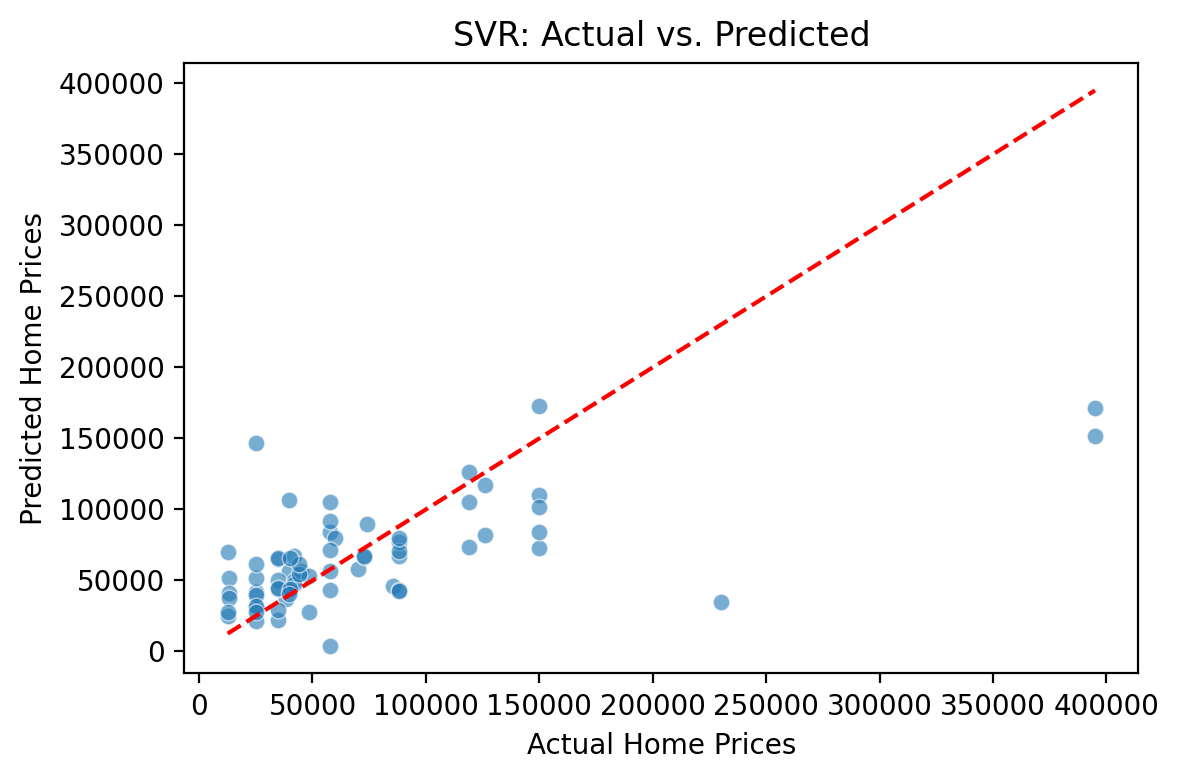

In [92]:
#Plot Philly SV regression
plot_regression(y_test, y_pred)

### Detroit model

In [68]:
#Philly SV regression
features = ['median_income', 'total_businesses', 'other_per_1k', 'total_per_1k', 'unemploy_pct']
target = 'sale_price'

selected_columns_det = selected_columns_det[selected_columns_det['bach_attainment'] != '-']

kernel='poly'
c_val=1.0
epsilon=0.01

y_test, y_pred = sv_regression(selected_columns_det, features, target, kernel, c_val, epsilon)

R² score: 0.480
MAE: 15975.09


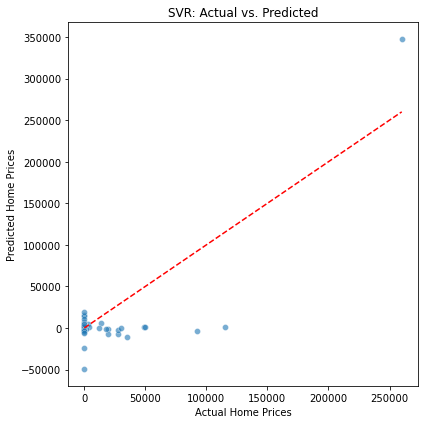

In [69]:
#Plot Philly SV regression
plot_regression(y_test, y_pred)

### Pittsburgh model

In [82]:
#Pitt. SV regression
features = ['median_income', 'bach_attainment', 'White_pct', 'Black_pct', 'Asian_pct', 'Other_pct',
            'nuis_per_1k', 'viol_per_1k', 'prop_per_1k', 'other_per_1k', 'total_per_1k']
target = 'sale_price'


kernel='rbf'
c_val=100
epsilon=0.75

y_test, y_pred = sv_regression(selected_columns_pitt, features, target, kernel, c_val, epsilon)

R² score: 0.017
MAE: 160368.72
